In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
     |████████████████████████████████| 704.8MB 20kB/s 


In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

import re
import nltk
import gc
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving data_sample_ulm.csv to data_sample_ulm.csv
User uploaded file "data_sample_ulm.csv" with length 6900900 bytes


In [0]:
TRAIN_SIZE = 0.8

DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
DATASET_PATH = 'data_sample_ulm.csv'
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [0]:
decode_map = {0: "NEGATIVE", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [0]:
df = pd.read_csv(DATASET_PATH, encoding=DATASET_ENCODING)
df.shape

(50000, 6)

In [0]:
df.head()

,target,ids,date,flag,user,text
0,0,1467842607,Mon Apr 06 22:28:09 PDT 2009,NO_QUERY,VanessaSingline,@BridgetsBeaches Thank you for letting people ...
1,0,2053909554,Sat Jun 06 06:03:15 PDT 2009,NO_QUERY,faisalkapadia,@sanasaleem mouth waters @ 3.1 mb per second b...
2,0,2302511871,Tue Jun 23 16:54:53 PDT 2009,NO_QUERY,autumnsvoice,Listening to music and wishing i could hang ou...
3,0,2325876685,Thu Jun 25 06:12:23 PDT 2009,NO_QUERY,chicharo,My exchange sister just left on the plane for ...
4,0,1957179475,Thu May 28 23:44:34 PDT 2009,NO_QUERY,HDrobiarz,Watching Leno for the second to last time on t...


In [0]:
def preprocess_2(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if stem:
            tokens.append(stemmer.stem(token))
        else:
            tokens.append(token)
    return " ".join(tokens)

In [0]:
df.text = df.text.apply(lambda x: preprocess_2(x))

In [0]:
from sklearn.model_selection import train_test_split
df_trn, df_val = train_test_split(df, stratify = df['target'], test_size = 0.2, random_state = 12)

In [0]:
df_trn.shape, df_val.shape

((40000, 6), (10000, 6))

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
learn = language_model_learner(data_lm,  arch = AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


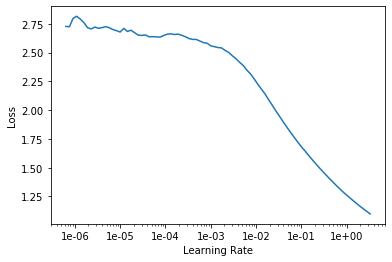

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
# Learning with Discriminative fine tuning
learn.fit_one_cycle(1, 1e-2)
learn.save_encoder('ft_enc')

epoch,train_loss,valid_loss,accuracy,time
0,0.891465,0.080771,0.988036,02:45


In [0]:
my_fbeta = FBeta(beta=1,average='macro')
learn.metrics = [accuracy, my_fbeta]
learn.metrics

[<function fastai.metrics.accuracy>,
 FBeta(average='macro', pos_label=1, eps=1e-09, beta=1)]

In [0]:
learn.save_encoder('ft_enc')

In [0]:
learn = text_classifier_learner(data_clas,arch=AWD_LSTM, drop_mult=0.7,metrics = [accuracy, my_fbeta])
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (40000 items)
x: TextList
xxbos xxunk,xxbos xxunk,xxbos xxunk,xxbos xxunk,xxbos xxunk
y: CategoryList
0,4,0,0,4
Path: .;

Valid: LabelList (10000 items)
x: TextList
xxbos xxunk,xxbos xxunk,xxbos xxunk,xxbos xxunk,xxbos xxunk
y: CategoryList
0,4,0,4,4
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(40, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(40, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
     

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


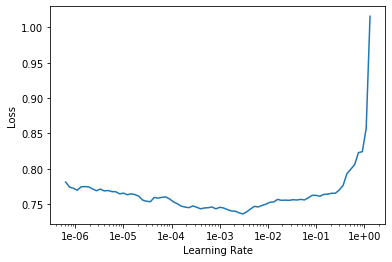

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.695030,0.694053,0.498600,0.337778,03:51
1,0.694729,0.693189,0.500000,0.337900,03:51
2,0.692715,0.693327,0.500400,0.338430,03:50


In [0]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,4976,4972
1,24,28
